# Mapping invasive species using supervised machine learning and AVIRIS-NG 

## Overview 

In this notebook, we will use existing data of verified land cover and alien species locations to extract spectra from AVIRIS NG surface reflectance data.

## Learning Objectives
1. Understand how to inspect and prepare data for machine learning models
2. Train and interpret a machine learning model
3. Apply a trained model to AVIRIS imagery to create alien species maps

### Load python modules

In [1]:
import geopandas as gpd
import xarray as xr
from shapely.geometry import box, mapping
import rioxarray as riox
import numpy as np
import hvplot.xarray
import holoviews as hv
import xvec
import matplotlib.pyplot as plt
import pandas as pd
from dask.diagnostics import ProgressBar
import warnings
#our functions
from utils import get_first_xr

warnings.filterwarnings('ignore')
hvplot.extension('bokeh')
%matplotlib inline


#### Open and inspect invasives data 
In this exercise we will be using a small dataset of manually collected invasive plant and land cover labels

In [2]:
#manually link the labels to the class

text_lab = ['Bare ground/Rock','Mature Fynbos','Recently burnt Fynbos','Wetland','Forest','Pine','Eucalyptus','Wattle','Water']
label = ['0','1','2','3','4','5','6','7','8']

lab_df = pd.DataFrame({
    'class': label,
    'text_lab': text_lab
})
lab_df

class               text_lab
0     0       Bare ground/Rock
1     1          Mature Fynbos
2     2  Recently burnt Fynbos
3     3                Wetland
4     4                 Forest
5     5                   Pine
6     6             Eucalyptus
7     7                 Wattle
8     8                  Water

In [3]:
#open the data
raw_data = gpd.read_file('/shared/users/gmoncrieff/ct_invasive.gpkg')
raw_data_utm = (raw_data
                .to_crs("EPSG:32734")
                .merge(lab_df, on='class', how='left')
               )
raw_data_utm.head()

class  group                        geometry          text_lab
0     0      2  POINT (264211.767 6198008.161)  Bare ground/Rock
1     0      1  POINT (257698.443 6240453.544)  Bare ground/Rock
2     0      1  POINT (260264.755 6239108.581)  Bare ground/Rock
3     0      1  POINT (258793.622 6239111.697)  Bare ground/Rock
4     0      1  POINT (261938.819 6238865.583)  Bare ground/Rock

In [4]:
#explore data in interactive map. color by class. use google sattelite basemap
(raw_data_utm[['text_lab','geometry']]
 .explore('text_lab',tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', attr='Google'))

#### find AVIRIS data
The Bioscape AVIRIS data is not yet stored in a publically searchable place like EMIT. We will need to use some extra data to figure out which AVIRIS scenes we want to work with. We have a coverage file which has the footprints of each AVIRIS scene. The flights we are interested in took place over the Cape Pensinsula on 2023-11-09

In [5]:
AVNG_Coverage = gpd.read_file('/shared/users/gmoncrieff/ANG_Coverage.geojson')
#filter dates to between midnight on 2023-11-09 and 23:59:59 on 2023-11-09
AVNG_CP = AVNG_Coverage[(AVNG_Coverage['end_time'] >= '2023-11-09 00:00:00') & (AVNG_Coverage['end_time'] <= '2023-11-09 23:59:59')]
#keep only AVNG_CP that intersects with raw_data

AVNG_CP = AVNG_CP.to_crs("EPSG:32734")
AVNG_CP = AVNG_CP[AVNG_CP.intersects(raw_data_utm.unary_union)]

#make a list of filenames
files = AVNG_CP['RFL s3'].tolist()
files_geo = AVNG_CP['geometry'].tolist()
files.pop(70)
files_geo.pop(70)

#filter to start time between
(AVNG_CP[['fid','geometry']]
 .explore('fid'))



Open a single file to inspect the data

In [6]:
test = xr.open_dataset(files[30], engine='kerchunk', chunks='auto')
test = test.where(test>0)
test

<xarray.Dataset> Size: 987MB
Dimensions:      (y: 779, wavelength: 425, x: 745)
Coordinates:
  * wavelength   (wavelength) float32 2kB 377.2 382.2 ... 2.496e+03 2.501e+03
  * x            (x) float64 6kB 2.602e+05 2.602e+05 ... 2.637e+05 2.637e+05
  * y            (y) float64 6kB 6.205e+06 6.205e+06 ... 6.201e+06 6.201e+06
Data variables:
    reflectance  (y, wavelength, x) float32 987MB dask.array<chunksize=(105, 425, 745), meta=np.ndarray>
    spatial_ref  float64 8B nan
Attributes: (12/19)
    description:          L2A Analytyical per-pixel surface retrieval
    samples:              745
    lines:                779
    bands:                425
    header offset:        0
    file type:            ENVI Standard
    ...                   ...
    band names:           ['channel_0', 'channel_1', 'channel_2', 'channel_3'...
    masked pixel noise:   2.697331666946411
    ang pge input files:  ['bad_element_file=/scratch/achlus/airborne_sds/ang...
    ang pge run command:  ['/scratch/achlus/airborne_sds/ang_l1b_radiance/emi...
    bbl:                  ['0', '1', '1', '1', '1', '1', '1', '1', '1', '1', ...
    data ignore value:    -9999

Plot a True Color image

In [7]:
test.sel(wavelength=[660, 570, 480], method="nearest").hvplot.rgb('x', 'y',
                                                                  rasterize=True,data_aspect=1,
                                                                  bands='wavelength',frame_width=400
)

:DynamicMap   []
   :RGB   [x,y]   (R,G,B)

Plot the red reflectance

In [8]:
test.sel({'wavelength': 660},method='nearest').hvplot('x', 'y',
                                                      rasterize=True, data_aspect=1,
                                                      cmap='magma',frame_width=400,clim=(0,0.3)
)

:DynamicMap   []
   :Image   [x,y]   (reflectance)

Now that we are happy with the data, we want to get the AVIRIS spectra at each label location. Below is a function that does this and returns the result as a xarray

In [9]:
#the function takes a filepath to a file on s3, and the point locations for extraction
def extract_points(file,geo, points):
    
    ds = xr.open_dataset(file, engine='kerchunk', chunks='auto')
    
    # Clip the raw data to the bounding box
    points = points.clip(geo)
    print(f'got {points.shape[0]} point from {file}')
    
    # Extract points
    extracted = ds.xvec.extract_points(points['geometry'], x_coords="x", y_coords="y",index=True)
    
    return extracted

Now we iterate through the list of files. Each files only overlaps with a few of the points, but all the files will eventually cover all the points once we combine the results

In [10]:
ds_all = [extract_points(file,geo, raw_data_utm) for file, geo in zip(files,files_geo)]

#combine the results into a single xarray
ds_all  = xr.concat(ds_all, dim='file')
ds_all

got 2 point from s3://bioscape-data/AVNG/ang20231109t125547/ang20231109t125547_012/ang20231109t125547_012_L2A_OE_main_27577724_RFL_ORT.json
got 1 point from s3://bioscape-data/AVNG/ang20231109t125547/ang20231109t125547_018/ang20231109t125547_018_L2A_OE_main_27577724_RFL_ORT.json
got 1 point from s3://bioscape-data/AVNG/ang20231109t125547/ang20231109t125547_020/ang20231109t125547_020_L2A_OE_main_27577724_RFL_ORT.json
got 3 point from s3://bioscape-data/AVNG/ang20231109t125547/ang20231109t125547_021/ang20231109t125547_021_L2A_OE_main_27577724_RFL_ORT.json
got 1 point from s3://bioscape-data/AVNG/ang20231109t130728/ang20231109t130728_000/ang20231109t130728_000_L2A_OE_main_27577724_RFL_ORT.json
got 3 point from s3://bioscape-data/AVNG/ang20231109t130728/ang20231109t130728_001/ang20231109t130728_001_L2A_OE_main_27577724_RFL_ORT.json
got 4 point from s3://bioscape-data/AVNG/ang20231109t130728/ang20231109t130728_002/ang20231109t130728_002_L2A_OE_main_27577724_RFL_ORT.json
got 10 point from s3

<xarray.Dataset> Size: 40MB
Dimensions:      (wavelength: 425, geometry: 317, file: 73)
Coordinates:
  * wavelength   (wavelength) float32 2kB 377.2 382.2 ... 2.496e+03 2.501e+03
  * geometry     (geometry) object 3kB POINT (266843.7679640446 6223778.39226...
    index        (file, geometry) float64 185kB 241.0 240.0 nan ... nan nan nan
Dimensions without coordinates: file
Data variables:
    reflectance  (file, geometry, wavelength) float32 39MB dask.array<chunksize=(1, 317, 425), meta=np.ndarray>
    spatial_ref  (file) int64 584B 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Indexes:
    geometry  GeometryIndex (crs=EPSG:32734)
Attributes: (12/19)
    description:          L2A Analytyical per-pixel surface retrieval
    samples:              866
    lines:                699
    bands:                425
    header offset:        0
    file type:            ENVI Standard
    ...                   ...
    band names:           ['channel_0', 'channel_1', 'channel_2', 'channel_3'...
    masked pixel noise:   2.7336463928222656
    ang pge input files:  ['bad_element_file=/scratch/achlus/airborne_sds/ang...
    ang pge run command:  ['/scratch/achlus/airborne_sds/ang_l1b_radiance/emi...
    bbl:                  ['0', '1', '1', '1', '1', '1', '1', '1', '1', '1', ...
    data ignore value:    -9999

Because some points are covered by multiple AVIRIS scenes, some points have multiple spectra for each location, and thus we have an extra dim in this. We will simply extract the first valid reflectance measurement for each geometry. We have a custom function to do this `get_first_xr()`

In [11]:
ds = get_first_xr(ds_all)
ds

<xarray.Dataset> Size: 546kB
Dimensions:      (wavelength: 425, index: 317)
Coordinates:
  * wavelength   (wavelength) float32 2kB 377.2 382.2 ... 2.496e+03 2.501e+03
    geometry     (index) object 3kB POINT (266843.7679640446 6223778.39226230...
  * index        (index) int64 3kB 241 240 291 20 18 17 ... 52 51 137 290 82 246
Data variables:
    reflectance  (index, wavelength) float32 539kB dask.array<chunksize=(317, 425), meta=np.ndarray>

This data set just has the spectra. We need to merge with point data to add labels

In [12]:
class_xr =raw_data_utm[['class','group']].to_xarray()
ds = ds.merge(class_xr.astype(int),join='left')
ds

<xarray.Dataset> Size: 551kB
Dimensions:      (wavelength: 425, index: 317)
Coordinates:
  * wavelength   (wavelength) float32 2kB 377.2 382.2 ... 2.496e+03 2.501e+03
  * index        (index) int64 3kB 241 240 291 20 18 17 ... 52 51 137 290 82 246
    geometry     (index) object 3kB POINT (266843.7679640446 6223778.39226230...
Data variables:
    reflectance  (index, wavelength) float32 539kB dask.array<chunksize=(317, 425), meta=np.ndarray>
    class        (index) int64 3kB 8 8 8 1 0 0 1 1 4 8 3 ... 1 1 0 1 2 2 5 8 3 8
    group        (index) int64 3kB 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 2 1 1 1 2 2 1

We have defined all the operations we want, but becasue of xarrays lazy compution, the calculations have not yet been done. We will now force it to perform this calculations. We want to keep the result in chunks, so we use `.persist()` and not `.compute()`. This should take approx __2 - 3 mins__

In [13]:
with ProgressBar():
 dsp = ds.persist()

[########################################] | 100% Completed | 283.87 s


In [14]:
dsp

<xarray.Dataset> Size: 551kB
Dimensions:      (wavelength: 425, index: 317)
Coordinates:
  * wavelength   (wavelength) float32 2kB 377.2 382.2 ... 2.496e+03 2.501e+03
  * index        (index) int64 3kB 241 240 291 20 18 17 ... 52 51 137 290 82 246
    geometry     (index) object 3kB POINT (266843.7679640446 6223778.39226230...
Data variables:
    reflectance  (index, wavelength) float32 539kB dask.array<chunksize=(317, 425), meta=np.ndarray>
    class        (index) int64 3kB 8 8 8 1 0 0 1 1 4 8 3 ... 1 1 0 1 2 2 5 8 3 8
    group        (index) int64 3kB 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 2 1 1 1 2 2 1

#### Inspect AVIRIS spectra

In [15]:
dsp_plot = dsp.where(dsp['class']==5, drop=True)
dsp_plot['reflectance'].hvplot.line(x='wavelength',by='index',
                                    color='green',ylim=(0,0.5),alpha=0.5,legend=False)

:NdOverlay   [index]
   :Curve   [wavelength]   (reflectance)

> At this point in a real machine learning workflow, you should closely inspect the spectra you have for each class. Do they make sense? Are there some spectra that look weird? You should re-evaluate your data to make sure that the assigned labels are true. This is a very important step

#### Prep data for ML model

As you will know, not all of the wavelengths in the data are of equal quality, some will be degraded by atmospheric water absorption features or other factors. We should remove the bands from the analysis that we are not confident of. Probably the best way to do this is to use the uncertainties provided along with the reflectance files. We will simply use some prior knowledge to screen out the worst bands. 

In [16]:
wavelengths_to_drop = dsp.wavelength.where(
    (dsp.wavelength < 450) |
    (dsp.wavelength >= 1340) & (dsp.wavelength <= 1480) |
    (dsp.wavelength >= 1800) & (dsp.wavelength <= 1980) |
    (dsp.wavelength > 2400), drop=True
)

# Use drop_sel() to remove those specific wavelength ranges
dsp = dsp.drop_sel(wavelength=wavelengths_to_drop)

mask = (dsp['reflectance'] > -1).all(dim='wavelength')  # Create a mask where all values along 'z' are non-negative
dsp = dsp.sel(index=mask)

dsp

<xarray.Dataset> Size: 416kB
Dimensions:      (wavelength: 325, index: 311)
Coordinates:
  * wavelength   (wavelength) float32 1kB 452.3 457.3 ... 2.391e+03 2.396e+03
  * index        (index) int64 2kB 241 240 291 20 18 17 ... 52 51 137 290 82 246
    geometry     (index) object 2kB POINT (266843.7679640446 6223778.39226230...
Data variables:
    reflectance  (index, wavelength) float32 404kB dask.array<chunksize=(311, 325), meta=np.ndarray>
    class        (index) int64 2kB 8 8 8 1 0 0 1 1 4 8 3 ... 1 1 0 1 2 2 5 8 3 8
    group        (index) int64 2kB 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 2 1 1 1 2 2 1

Next we will normalize the data, there are a number of difference normalizations to try. In a ML workflow you should try a few and see which work best. We will only use a Brightness Normalization. In essence, we scale the reflectance of each wavelength by the total brightness of the spectra. This retains info on important shape features and relative reflectance, and removes info on absolute reflectance.

In [17]:
# Calculate the L2 norm along the 'wavelength' dimension
l2_norm = np.sqrt((dsp['reflectance'] ** 2).sum(dim='wavelength'))

# Normalize the reflectance by dividing by the L2 norm
dsp['reflectance'] = dsp['reflectance'] / l2_norm

Plot our new, clean spectra

In [18]:
dsp_norm_plot = dsp.where(dsp['class']==5, drop=True)
dsp_norm_plot['reflectance'].hvplot.line(x='wavelength',by='index',
                                         color='green',ylim=(-0.1,0.2),alpha=0.5,legend=False)



:NdOverlay   [index]
   :Curve   [wavelength]   (reflectance)

#### Train and evaluate ML model

We will be using a model called `xgboost`. There are many, many different kinds of ML models. `xgboost` is a class of models called gradient boosted trees, related to random forests. When used for classification, random forests work by creating multiple decision trees, each trained on a random subset of the data and features, and then averaging their predictions to improve accuracy and reduce overfitting. Gradient boosted trees differ in that they build trees sequentially, with each new tree focusing on correcting the errors of the previous ones. This sequential approach allows `xgboost` to create highly accurate models by iteratively refining predictions and addressing the weaknesses of earlier trees.

Import the Machine Learning libraries we will use

In [19]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

Our dataset has a label indicating which set (training or test), our data belong to. We wil use this to split it

In [20]:
dtrain = dsp.where(dsp['group']==1,drop=True)
dtest = dsp.where(dsp['group']==2,drop=True)

#create separte datasets for labels and features
y_train = dtrain['class'].values.astype(int)
y_test = dtest['class'].values.astype(int)
X_train = dtrain['reflectance'].values
X_test = dtest['reflectance'].values

#### Train ML model
The steps we will go through to train the model are:

First, we define the hyperparameter grid. Initially, we set up a comprehensive grid (param_grid) with multiple values for several hyperparameters of the XGBoost model. 

Next, we create an XGBoost classifier object using the XGBClassifier class from the XGBoost library.

We then set up the GridSearchCV object using our defined XGBoost model and the hyperparameter grid. GridSearchCV allows us to perform an exhaustive search over the specified hyperparameter values to find the optimal combination that results in the best model performance. We choose a 5-fold cross-validation strategy (cv=5), meaning we split our training data into five subsets to validate the model's performance across different data splits. We use accuracy as our scoring metric to evaluate the models.

After setting up the grid search, we fit the GridSearchCV object to our training data (X_train and y_train). This process involves training multiple models with different hyperparameter combinations and evaluating their performance using cross-validation. Our goal is to identify the set of hyperparameters that yields the highest accuracy.

Once the grid search completes, we print out the best set of hyperparameters and the corresponding best score. The grid_search.best_params_ attribute provides the combination of hyperparameters that achieved the highest cross-validation accuracy, while the grid_search.best_score_ attribute shows the corresponding accuracy score. Finally, we extract the best model (best_model) from the grid search results. This model is trained with the optimal hyperparameters and is ready for making predictions or further analysis in our classification task.

This will take approx __30 seconds__

In [21]:
# Define the hyperparameter grid

param_grid = {
    'max_depth': [5],
    'learning_rate': [0.1],
    'subsample': [0.75],
    'n_estimators' : [50,100]
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier(tree_method='hist')

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
best_model = grid_search.best_estimator_

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.75}
Best score:  0.6613877551020408


#### Evaluate model performance

We will use our best model to predict the classes of the test data  Then, we calculate the F1 score using f1_score, which balances precision and recall, and print it to evaluate overall performance.

Next, we assess how well the model performs for predicting Pine trees by calculating its precision and recall. Precision measures the accuracy of the positive predictions.  It answers the question, "Of all the instances we labeled as Pines, how many were actually Pines?". Recall measures the model's ability to identify all actual positive instances. It answers the question, "Of all the actual Pines, how many did we correctly identify?". You may also be familiar with the terms Users' and Producers' Accuracy. Precision  = User' Accuracy, and Recall = Producers' Accuracy.

Finally, we create and display a confusion matrix to visualize the model's prediction accuracy across all classes

Accuracy: 0.7142857142857143
F1 Score (weighted): 0.6897560640417785
Precision for Class 5: 0.5
Recall for Class 5: 0.6666666666666666


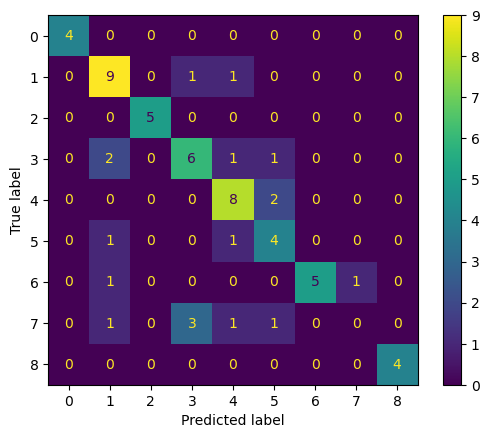

In [22]:
y_pred = best_model.predict(X_test)

# Step 2: Calculate acc and F1 score for the entire dataset
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' accounts for class imbalance
print(f"F1 Score (weighted): {f1}")

# Step 3: Calculate precision and recall for class 5 (Pine)
precision_class_5 = precision_score(y_test, y_pred, labels=[5], average='macro', zero_division=0)
recall_class_5 = recall_score(y_test, y_pred, labels=[5], average='macro', zero_division=0)

print(f"Precision for Class 5: {precision_class_5}")
print(f"Recall for Class 5: {recall_class_5}")

# Step 4: Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

#### Interpret and understand ML model

Model interpretation in machine learning is crucial for understanding how models make predictions, especially in complex models. SHAP (SHapley Additive exPlanations) scores are a popular method for interpreting model predictions. They provide a way to explain the output of any machine learning model by assigning each feature an importance value for a particular prediction.

SHAP scores explain the contribution of each feature to a model's prediction using concepts from cooperative game theory. They start with a baseline prediction, which is the average prediction across all data points. For each feature, SHAP calculates how much the prediction changes when the feature is included compared to when it is not, considering all possible combinations of features. The SHAP value for a feature is the average of its contributions across all combinations, ensuring fair distribution. Positive SHAP values indicate the feature increases the prediction, while negative values suggest it decreases it.

In [23]:
import shap
shap.initjs()

# Initialize the SHAP Tree Explainer for XGBoost
explainer = shap.TreeExplainer(best_model,feature_names=list(map(str, dsp.wavelength.values.astype(int))))
shap_values = explainer(X_test)

We can select an indiviual prediction to inspect how the input features have influenced it's assignment to a class

In [24]:
sel_in = 43

print(f'predicted class: {lab_df.loc[y_pred[sel_in],'text_lab']}')
print(f'true class: {lab_df.loc[y_test[sel_in],'text_lab']}')

predicted class: Eucalyptus
true class: Eucalyptus


In [25]:
#shap.plots.waterfall(shap_values[sel_in,:,y_test[sel_in]])


#lables for wavelength in plot
feats =  dsp.wavelength.values.astype(int)
feats = map(str,feats)
shap.force_plot(explainer.expected_value[y_test[sel_in]], shap_values.values[sel_in,:,y_test[sel_in]], pd.DataFrame(X_test).iloc[sel_in, :],link='logit',feature_names=list(feats))

We can also inspect the importance of features across all instances of a particular class

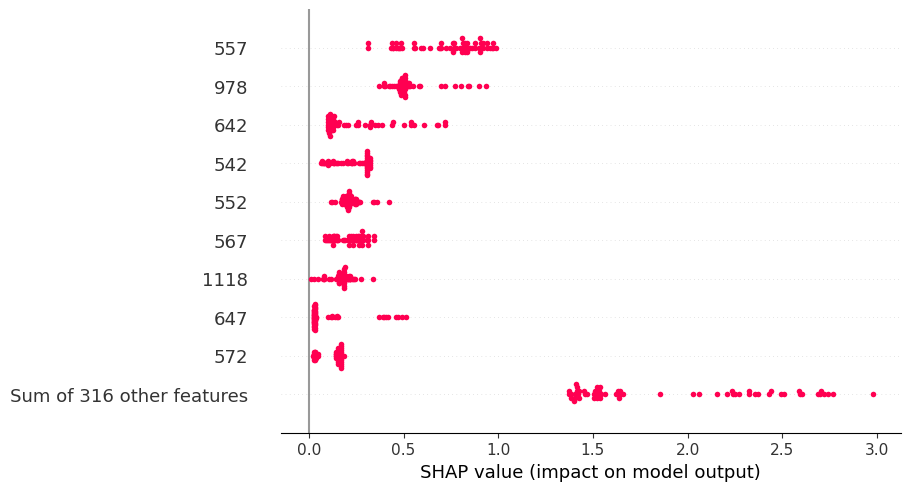

In [26]:
shap.plots.beeswarm(shap_values[:,:,y_test[sel_in]].abs, color="shap_red")

Finally, lets overlay this on the actual spectra for a individual observation to understand how spectral features are contributing to our predictions

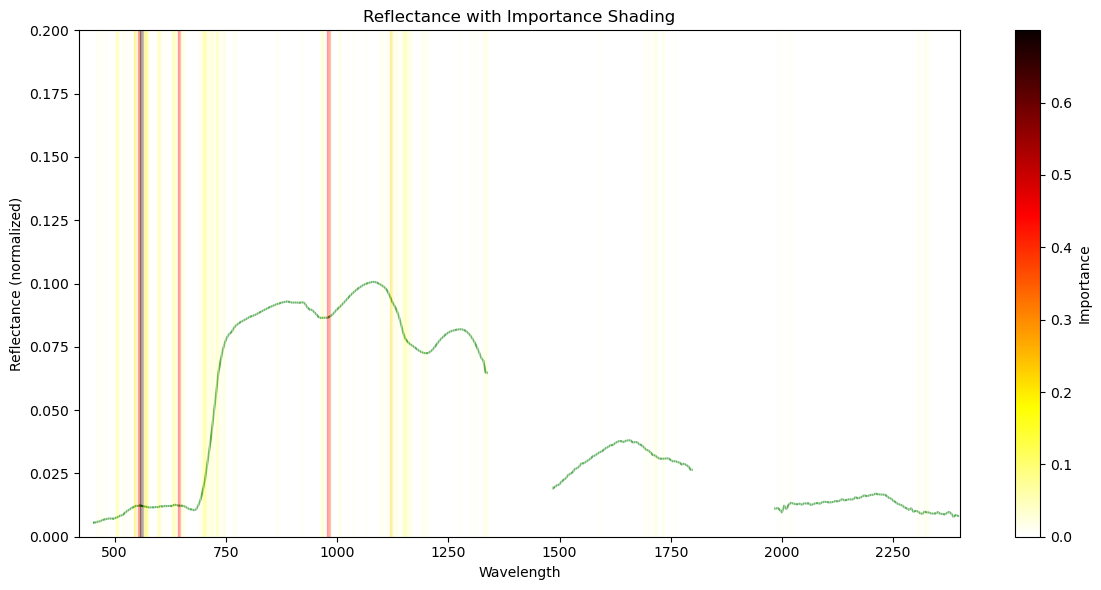

In [27]:
#plot spectra and importance
importance = np.abs(shap_values[sel_in,:,y_test[sel_in]].values)
# Create the base plot
fig, ax = plt.subplots(figsize=(12, 6))

# Get the wavelength and importance data
wavelength = dsp['wavelength'].values
importance = importance  # Make sure this aligns with your wavelength data

# Create a colormap
cmap = plt.get_cmap('hot').reversed()  # You can choose a different colormap if you prefer

# Normalize importance values to [0, 1] for colormap
norm = plt.Normalize(importance.min(), importance.max())

# Add shading
for i in range(len(wavelength) - 1):
    ax.fill_between([wavelength[i], wavelength[i+1]], 0, 1, 
                    color=cmap(norm(importance[i])), alpha=0.3)

# Add a colorbar to show the importance scale
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Importance')

# Add white blocks to obscure specified regions
ax.fill_between([0,450], 0, 1, color='white')
ax.fill_between([1340,1480], 0, 1, color='white')
ax.fill_between([1800,1980], 0, 1, color='white')
ax.fill_between([2400,2500], 0, 1, color='white')
ax.set_xlim(420,2400)

plot_xr = xr.DataArray(X_test[sel_in], coords=[wavelength], dims=["wavelength"])
plot_xr.plot.line(x='wavelength', color='green', ylim=(0, 0.2), ax=ax,zorder=0)

plt.title('Reflectance with Importance Shading')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance (normalized)')

plt.tight_layout()
plt.show()

#### Predict over multiple AVIRIS scenes

We now have a trained model and are ready to deploy it to generate predictions across an entire AVIRIS scene and map the distribution of invasive plants. This involves handling a large volume of data, so we need to write the code to do this intelligently. We will accomplish this by applying the `.predict()` method of our trained model in parallel across the chunks of the AVIRIS xarray. The model will receive one chunk at a time so that the data is not too large, but it will be able to perform this operation in parallel across multiple chunks, and therefore will not take too long.

Our model was only trained on data covering natural vegetaiton in the Cape Peninsula, It is important that we only predict in the areas that match our training data. We will therefore filter to scenes that cover the Cape Peninsula and mask out non-protected areas

In [28]:
#south africa protected areas
SAPAD = (gpd.read_file('/shared/users/gmoncrieff/SAPAD_2024.gpkg')
         .to_crs("EPSG:32734")
         .query("SITE_TYPE!='Marine Protected Area'")
        )

# Get the bounding box of the training data
bbox = raw_data_utm.total_bounds  # (minx, miny, maxx, maxy)
gdf_bbox = gpd.GeoDataFrame({'geometry': [box(*bbox)]}, crs=raw_data_utm.crs)  # Specify the CRS
gdf_bbox['geometry'] = gdf_bbox.buffer(500)

# protected areas that intersect with the training data
SAPAD_CT = SAPAD.overlay(gdf_bbox,how='intersection')

#keep only AVIRIS scenes that intersects with CT protected areas
AVNG_sapad = AVNG_CP[AVNG_CP.intersects(SAPAD_CT.unary_union)]

#a list of files to predict
files_sapad = AVNG_sapad['RFL s3'].tolist()
files_sapad.pop(69)
#get the geometries of the protected areas for masking later
geometries_sapad = SAPAD_CT.geometry.apply(mapping)

#how many files?
len(files_sapad)

72

In [29]:
AVNG_sapad[['fid','geometry']].explore('fid')

Here is the function that we will actually apply to each chunk. Simple really. The hard work is getting the data into and out of this function

In [30]:
def predict_on_chunk(chunk, model):
    probabilities = model.predict_proba(chunk)
    return probabilities

Now we define the funciton that takes as input the path to the AVIRIS file and pass the data to the predict function. THhs is composed of 4 parts:

Part 1: Opens the AVIRIS data file using xarray and sets a condition to identify valid data points where reflectance values are greater than zero.

Part 2: Applies all the transformations that need to be done before the data goes to the model. It the spatial dimensions (x and y) into a single dimension, filters wavelengths, and normalizes the reflectance data.

Part 3: Applies the machine learning model to the normalized data in parallel, predicting class probabilities for each data point using xarray's apply_ufunc method. Most of the function invloves defining what to do with the dimensions of the old dataset and the new output

Part 4: Unstacks the data to restore its original dimensions, sets spatial dimensions and coordinate reference system (CRS), clips the data, and transposes the data to match expected formats before returning the results.

In [31]:
def predict_xr(file,geometries):

    #part 1 - opening file
    #open the file
    print(f'file: {file}')
    ds = xr.open_dataset(file, engine='kerchunk', chunks='auto')

    #condition to use for masking no data later
    condition = (ds['reflectance'] > -1).any(dim='wavelength')

    #stack the data into a single dimension. This will be important for applying the model later
    ds = ds.stack(sample=('x','y'))
    
    #part 2 - pre-processing
    #remove bad wavelenghts
    wavelengths_to_drop = ds.wavelength.where(
        (ds.wavelength < 450) |
        (ds.wavelength >= 1340) & (ds.wavelength <= 1480) |
        (ds.wavelength >= 1800) & (ds.wavelength <= 1980) |
        (ds.wavelength > 2400), drop=True
    )
    # Use drop_sel() to remove those specific wavelength ranges
    ds = ds.drop_sel(wavelength=wavelengths_to_drop)
    
    #normalise the data
    l2_norm = np.sqrt((ds['reflectance'] ** 2).sum(dim='wavelength'))
    ds['reflectance'] = ds['reflectance'] / l2_norm
    
    #part 3 - apply the model over chunks
    result = xr.apply_ufunc(
        predict_on_chunk,
        ds['reflectance'],
        input_core_dims=[['wavelength']],#input dim with features
        output_core_dims=[['class']],  # name for the new output dim
        exclude_dims=set(('wavelength',)),  #dims to drop in result
        output_sizes={'class': 9}, #length of the new dimension
        output_dtypes=[np.float32],
        dask="parallelized",
        kwargs={'model': best_model}
    )

    #part 4 - post-processing
    result = result.where((result >= 0) & (result <= 1), np.nan) #valid values
    result = result.unstack('sample') #remove the stack
    result = result.rio.set_spatial_dims(x_dim='x',y_dim='y') #set the spatial dims
    result = result.rio.write_crs("EPSG:32734") #set the CRS
    result = result.rio.clip(geometries).where(condition) #clip to the protected areas and no data
    result = result.transpose('class', 'y', 'x') #transpose the data rio expects it this way
    return result

Before we blast through 100s of GB of data, lets test that it works on a single file

In [32]:
test  = predict_xr(files_sapad[46],geometries_sapad)
test

file: s3://bioscape-data/AVNG/ang20231109t134249/ang20231109t134249_011/ang20231109t134249_011_L2A_OE_main_27577724_RFL_ORT.json


<xarray.DataArray 'reflectance' (class: 9, y: 717, x: 651)> Size: 17MB
dask.array<transpose, shape=(9, 717, 651), dtype=float32, chunksize=(9, 121, 111), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 5kB 2.573e+05 2.573e+05 ... 2.605e+05 2.605e+05
  * y            (y) float64 6kB 6.231e+06 6.231e+06 ... 6.228e+06 6.228e+06
    spatial_ref  int64 8B 0
Dimensions without coordinates: class

Pretty good. Lets look at the result

In [33]:
test = test.rio.reproject("EPSG:4326",nodata=np.nan)
test.isel({'class':0}).hvplot(tiles=hv.element.tiles.EsriImagery(), 
                              project=True,rasterize=True,clim=(0,1),
                              cmap='magma',frame_width=400,data_aspect=1,alpha=0.5)

:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [x,y]   (reflectance)

ML models typically provide a single prediction of the most likely outcomes. You can also get probability-like scores (values from 0 to 1) from these models, but they are not true probabilities. If the model gives you a score of 0.6, that means it is more likely than a prediction of 0.5, and less likely than 0.7. However, it does not mean that in a large sample your prediction would be right 60 times out of 100. To get calibrated probabilities from our models, we have to apply additional steps. We can also get a set of predictions from models rather than a single prediction, which reflects the model's true uncertainty using a technique called conformal predictions. Read more about conformal prediction for geospatial machine learning in this amazing paper:

[Singh, G., Moncrieff, G., Venter, Z., Cawse-Nicholson, K., Slingsby, J., & Robinson, T. B. (2024). Uncertainty quantification for probabilistic machine learning in earth observation using conformal prediction. Scientific Reports, 14(1), 16166.](https://www.nature.com/articles/s41598-024-65954-w)

OK, now we are ready to go. This wont take long, as we have not yet ask it to perform the computation

In [34]:
grid_pred = [predict_xr(fi,geometries_sapad) for fi in files_sapad]

file: s3://bioscape-data/AVNG/ang20231109t125547/ang20231109t125547_012/ang20231109t125547_012_L2A_OE_main_27577724_RFL_ORT.json
file: s3://bioscape-data/AVNG/ang20231109t125547/ang20231109t125547_018/ang20231109t125547_018_L2A_OE_main_27577724_RFL_ORT.json
file: s3://bioscape-data/AVNG/ang20231109t125547/ang20231109t125547_020/ang20231109t125547_020_L2A_OE_main_27577724_RFL_ORT.json
file: s3://bioscape-data/AVNG/ang20231109t125547/ang20231109t125547_021/ang20231109t125547_021_L2A_OE_main_27577724_RFL_ORT.json
file: s3://bioscape-data/AVNG/ang20231109t130728/ang20231109t130728_000/ang20231109t130728_000_L2A_OE_main_27577724_RFL_ORT.json
file: s3://bioscape-data/AVNG/ang20231109t130728/ang20231109t130728_001/ang20231109t130728_001_L2A_OE_main_27577724_RFL_ORT.json
file: s3://bioscape-data/AVNG/ang20231109t130728/ang20231109t130728_002/ang20231109t130728_002_L2A_OE_main_27577724_RFL_ORT.json
file: s3://bioscape-data/AVNG/ang20231109t130728/ang20231109t130728_003/ang20231109t130728_003_L2

#### Merge and mosaic results

The results are now available as a list of xarrays, one for each scence. We want to combine these together into a single seamless mosaic for the entire Cape Peninsula. Fortunatley we dont have to write a ton of code to do this as `rioxarray` already has a mosaic function

In [35]:
from rioxarray.merge import merge_arrays

This will force computation and take about 10-30 mins to run on a 4 core, 16GB RAM machine. We wont run this, but rather load the result I computed earlier

In [36]:
#merged = merge_arrays(grid_pred,nodata=np.nan)
#merged = merged.rio.reproject("EPSG:4326")
#merged.rio.to_raster('/shared/users/gmoncrieff/ct_invasive.tiff',driver="COG")

### Restart!
The file we are about to load is large, and at the limit of what the SMCE machine can handle. If we restart the kernel, we will remove all existing data and free up space. We will then need to reload packages

In [1]:
import xarray as xr
import rioxarray as riox
import hvplot.xarray
import holoviews as hv
hvplot.extension('bokeh')

In [2]:
merged = xr.open_dataset('/shared/users/gmoncrieff/ct_invasive.tiff', engine='rasterio', chunks='auto')
merged

<xarray.Dataset> Size: 2GB
Dimensions:      (band: 9, x: 4240, y: 9952)
Coordinates:
  * band         (band) int64 72B 1 2 3 4 5 6 7 8 9
  * x            (x) float64 34kB 18.31 18.31 18.31 18.31 ... 18.5 18.5 18.5
  * y            (y) float64 80kB -33.91 -33.91 -33.91 ... -34.36 -34.36 -34.36
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 2GB dask.array<chunksize=(5, 2560, 2560), meta=np.ndarray>

view the result

In [3]:
merged.isel({'band':6}).hvplot(x='x',y='y',
                               tiles='ESRI',geo=True,
                                project=True,rasterize=True,
                                cmap='magma',clim=(0,1), frame_width=400,data_aspect=1,alpha=0.5)

:DynamicMap   []
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [x,y]   (band_data)

> Now we can inspect our results. Where do they look good? Where do they look bad? We should at this point return to the beginning of our workflow and refine every step of the process. Probably most importantly we should update our training data to include points that correct the errors that we see in our earlier outputs. This process of using early predictions to update our data is called 'Active Learning'

### credits

This lesson has borrowed from:    

[Land cover mapping example on Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/docs/tutorials/landcover) 
